# Looking into Estimating Nu losses
Wanna use pynucastro so gonna try and verify that I'm doing things "right" etc.

In [2]:
import pandas as pd
import numpy as np
import pynucastro as pyna
import matplotlib.pyplot as plt
import unyt

In [3]:
prof_dir = "/home/biboyd/workspace/nersc_sims/myfix_urca2048_lev4/profiles/"
full_df = pd.read_csv(f"{prof_dir}/plt0163536_all_fields.csv", index_col=0)
real_rad = full_df['radius'].to_numpy()/1e5
real_ratio = full_df['X(ne23)'].to_numpy()/full_df['X(na23)'].to_numpy()

In [4]:
rl = pyna.ReacLibLibrary()
rl_rates = rl.get_rate_by_name(["c12(c12,a)ne20",
                                "c12(c12,n)mg23",
                                "c12(c12,p)na23",
                                "c12(a,g)o16"])

tl = pyna.TabularLibrary()
tl_rates = tl.get_rate_by_name(["na23(,)ne23",
                                "ne23(,)na23"])

urca_net = pyna.RateCollection(rates=rl_rates+tl_rates)

In [5]:
def calc_weak_rates(full_df):
    # reduce the dataframe to necessary fields in right order
    cols = ['rho', 'tfromp', 'X(n)', 'X(h1)', 'X(he4)', 'X(c12)', 'X(o16)', 
            'X(ne20)', 'X(ne23)', 'X(na23)', 'X(mg23)']
    df = full_df[cols]

    comp = pyna.Composition(urca_net.unique_nuclei)
    
    # arrays to save rate and nuloss calculations
    ecap_rate_arr = np.empty(len(df))
    bdecay_rate_arr = np.empty(len(df))

    ecap_nu_loss_arr = np.empty(len(df))
    bdecay_nu_loss_arr = np.empty(len(df))

    # loop through and calc rate at each radial bin
    for i in range(len(df)):
        curr_comp = df.iloc[i, 2:].to_numpy()
        rho = df.iloc[i, 0]
        T = df.iloc[i, 1]
        
        comp.set_array(curr_comp)
        Ye = comp.eval_ye()

        ecap_rate = urca_net.get_rate_by_name('na23(e,)ne23')
        bdecay_rate = urca_net.get_rate_by_name('ne23(,e)na23')
        
        ecap_rate_arr[i] = ecap_rate.eval(T, rhoY=rho*Ye)
        bdecay_rate_arr[i] = bdecay_rate.eval(T, rhoY=rho*Ye)
        
        ecap_nu_loss_arr[i] = ecap_rate.get_nu_loss(T, rhoY=rho*Ye)
        bdecay_nu_loss_arr[i] = bdecay_rate.get_nu_loss(T, rhoY=rho*Ye)
    return ecap_rate_arr, bdecay_rate_arr, ecap_nu_loss_arr, bdecay_nu_loss_arr

Text(0, 0.5, 'Change in mass fraction of Ne23')

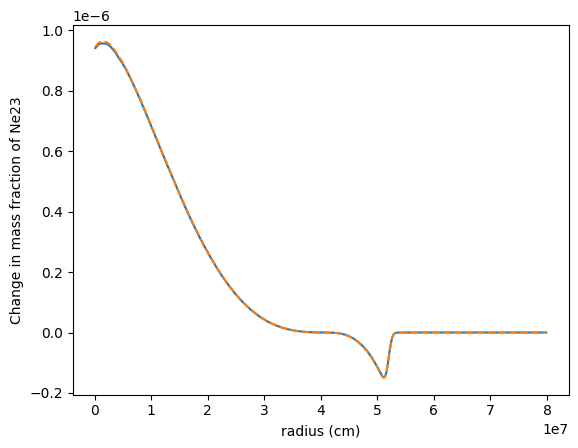

In [6]:
ecap_rate_arr, bdecay_rate_arr, ecap_nu_loss_arr, bdecay_nu_loss_arr = calc_weak_rates(full_df)
plt.plot(full_df['radius'], ecap_rate_arr * full_df['X(na23)']-bdecay_rate_arr * full_df['X(ne23)'])
plt.plot(full_df['radius'], full_df['omegadot(ne23)'], '--')
plt.xlabel('radius (cm)')
plt.ylabel("Change in mass fraction of Ne23")

Text(0.5, 1.0, 'orange with cburning. blue w/o')

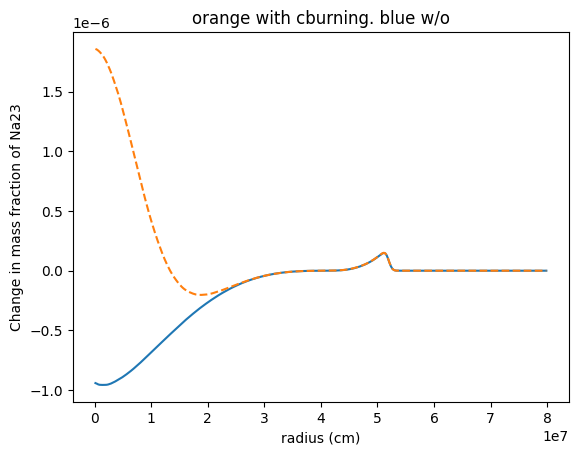

In [7]:
plt.plot(full_df['radius'], bdecay_rate_arr * full_df['X(ne23)'] - ecap_rate_arr * full_df['X(na23)'])
plt.plot(full_df['radius'], full_df['omegadot(na23)'], '--')
plt.xlabel('radius (cm)')
plt.ylabel("Change in mass fraction of Na23")
plt.title('orange with cburning. blue w/o')

Text(0, 0.5, 'specific energy loss rate to nu (erg/s/g)')

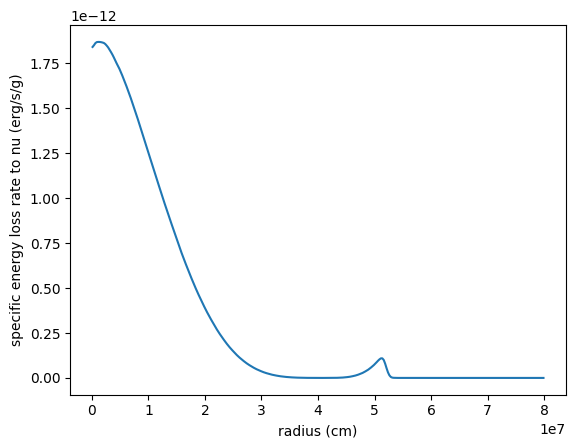

In [8]:
specific_nu_loss =  ecap_nu_loss_arr * full_df['X(na23)'] + bdecay_nu_loss_arr * full_df['X(ne23)']

plt.plot(full_df['radius'],specific_nu_loss)
plt.xlabel('radius (cm)')
plt.ylabel('specific energy loss rate to nu (erg/s/g)')

# Calculating Nu loss

Gotta calculate the mass in each sehll. Then divide by the radial bin size of the shell to recreate the plot in the Urca paper.

mass is just shells of density 4/3 pi Rout^3 - Rin^3 * density.

In [9]:
rad_arr = full_df['radius'].to_numpy()
dr = rad_arr[1] - rad_arr[0]

mass = 4./3. * np.pi * full_df['rho'].to_numpy() *  ((rad_arr + dr/2.)**3 - (rad_arr - dr/2.)**3)

4.266246537951195e+42


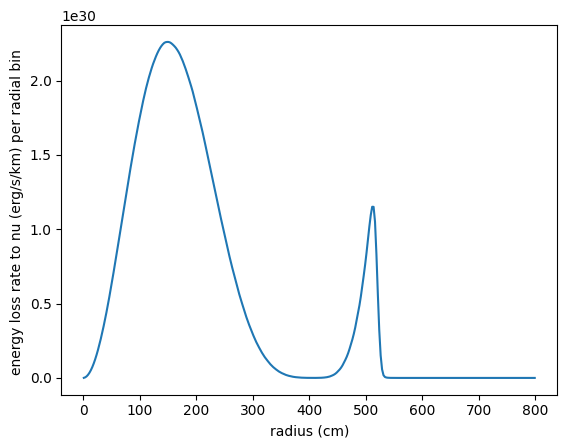

In [10]:
nu_loss_arr =  mass * (ecap_nu_loss_arr * full_df['X(na23)'] + bdecay_nu_loss_arr * full_df['X(ne23)']) * unyt.avogadros_number_mks.value / 23.
plt.plot(rad_arr/1e5, nu_loss_arr/dr/1e5)
plt.xlabel('radius (cm)')
plt.ylabel('energy loss rate to nu (erg/s/km) per radial bin ')
actual_nu_total = np.sum(nu_loss_arr)
print(actual_nu_total)

In [11]:
np.save('nuloss', nu_loss_arr, )

np.save('radius', rad_arr, )

Calculating the quick mixing limit. Takes the mass of ecaps and the mass of beta decays and looks at teh ratio between teh two.

note gotta limit to the convection zone or else will start greatly overcounting the beta decays that are occuring.

In [12]:
conv_size_arr = np.load("/home/biboyd/workspace/nersc_sims/myfix_urca2048_lev4/conv_stuff_over_time/conv_zone_over_time.npy")
Rconv = conv_size_arr[-2, 1]
conv_mass = mass[ np.where(rad_arr/1e5 < Rconv) ]
conv_ecap = ecap_rate_arr[ np.where(rad_arr/1e5 < Rconv) ]
conv_bdecay = bdecay_rate_arr[ np.where(rad_arr/1e5 < Rconv) ]

ecap_mass = np.sum(conv_mass * conv_ecap )
bdecay_mass = np.sum(conv_mass * conv_bdecay) #do i need to limit zones. I think the rates will do that for me?

ratio_of_ne23_to_na23 = ecap_mass/bdecay_mass
print(f"approx quick mixing limit {ratio_of_ne23_to_na23:0.3f}")

approx quick mixing limit 44.834


In [13]:
conv_sizes = np.arange(475, 700, 50)#np.linspace(400, 800, 20)
conv_quick_ratios = np.empty_like(conv_sizes)

for i, curr_Rconv in enumerate(conv_sizes):
    conv_mass = mass[ np.where(rad_arr/1e5 < curr_Rconv) ]
    conv_ecap = ecap_rate_arr[ np.where(rad_arr/1e5 < curr_Rconv) ]
    conv_bdecay = bdecay_rate_arr[ np.where(rad_arr/1e5 < curr_Rconv) ]
    
    ecap_mass = np.sum(conv_mass * conv_ecap )
    bdecay_mass = np.sum(conv_mass * conv_bdecay) #do i need to limit zones. I think the rates will do that for me?
    
    conv_quick_ratios[i] = ecap_mass/bdecay_mass


Text(0, 0.5, 'Quick limit approxed Ratio of Xna23/Xne23')

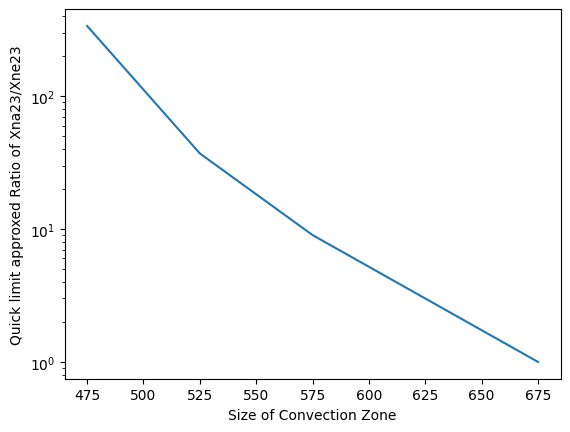

In [14]:
plt.plot(conv_sizes, conv_quick_ratios)
plt.yscale('log')
plt.xlabel('Size of Convection Zone')
plt.ylabel('Quick limit approxed Ratio of Xna23/Xne23')

## using a constant ratio this time
Cutting off where the Convection zone is defined

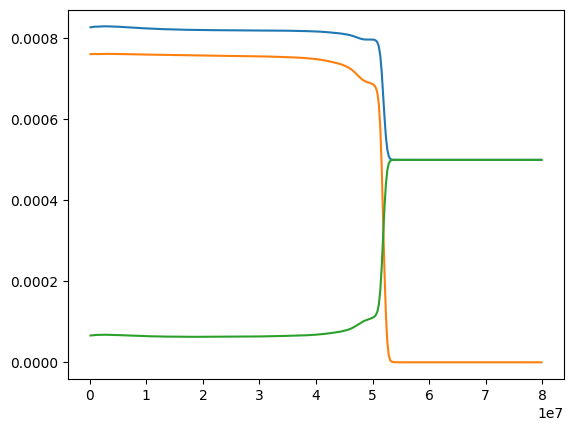

In [15]:
plt.plot(rad_arr, full_df['X(na23)'] + full_df['X(ne23)'])
plt.plot(rad_arr, full_df['X(ne23)'])
plt.plot(rad_arr, full_df['X(na23)'])


In [16]:
# define function that takes in ratio and proper data
# Then calculates the nu losses and such

def calc_const_nu_loss(Xne23_to_Xna23, df, mass, Rconv):

    rad_arr = df['radius'].to_numpy()
    total = df['X(na23)'].to_numpy() + df['X(ne23)'].to_numpy()
    
    # calculate the new Urca pair
    Xna23 = total/(1+Xne23_to_Xna23)
    Xne23 =  total/(1+1/Xne23_to_Xna23)
    df['X(na23)'] = Xna23
    df['X(ne23)'] = Xne23

    # calculate the new raw rates/nu losses
    ecap_rate_arr, bdecay_rate_arr, ecap_nu_loss_arr, bdecay_nu_loss_arr = calc_weak_rates(full_df)

    # restrict to looking just at the convection zone
    mask_non_conv = np.where(rad_arr/1e5 < Rconv)
    total = total[ mask_non_conv ]
    ratio_ecap_nu_loss = ecap_nu_loss_arr[ mask_non_conv ]
    ratio_bdecay_nu_loss = bdecay_nu_loss_arr[ mask_non_conv ]
    ratio_mass = mass[ mask_non_conv ]
    ratio_rad = rad_arr[mask_non_conv]
    
    Xna23 = Xna23[mask_non_conv]
    Xne23 = Xne23[mask_non_conv]
    
    # calculate energy lost
    nu_loss_arr =  ratio_mass * ( ratio_ecap_nu_loss * Xna23 + ratio_bdecay_nu_loss * Xne23) * unyt.avogadros_number_mks.value / 23.
    return ratio_rad, nu_loss_arr

5.4019654382076945e+42


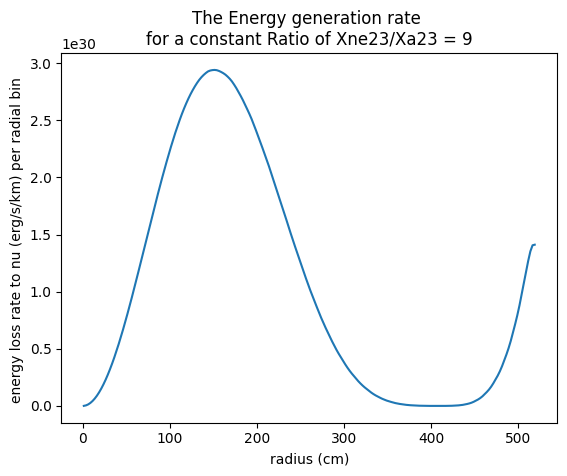

In [17]:

#size of convection zone
conv_size_arr = np.load("/home/biboyd/workspace/nersc_sims/myfix_urca2048_lev4/conv_stuff_over_time/conv_zone_over_time.npy")
Rconv = conv_size_arr[-2, 1]


curr_ratio=9.
ratio_rad, curr_nu_loss_arr = calc_const_nu_loss(curr_ratio, full_df, mass, Rconv)
plt.plot(ratio_rad/1e5, curr_nu_loss_arr/dr/1e5)
plt.title(f"The Energy generation rate \nfor a constant Ratio of Xne23/Xa23 = {curr_ratio:0.0f}")
plt.xlabel('radius (cm)')
plt.ylabel('energy loss rate to nu (erg/s/km) per radial bin ')

print(np.sum(curr_nu_loss_arr))

## Comparing the Actual vs the Ratios

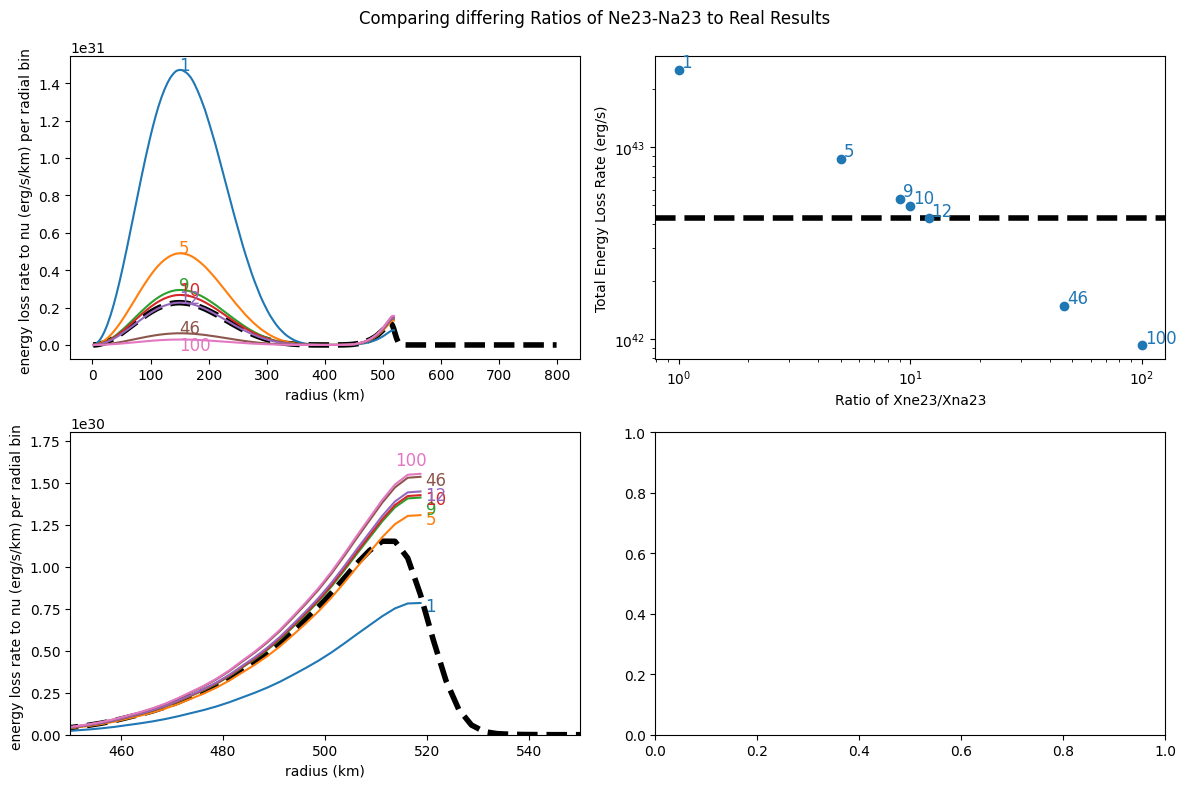

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axl, axr = axes[0, :]
axb = axes[1, 0]

axl.plot(rad_arr/1e5, nu_loss_arr/dr/1e5, 'k--', lw=4, label='Actual (avg)')
axb.plot(rad_arr/1e5, nu_loss_arr/dr/1e5, 'k--', lw=4, label='Actual (avg)')

# define a list of ratios to check
ratio_list = [1, 5, 9,10, 12, 46, 100]
nu_total = []

# plot out the radial things
for i, curr_ratio in enumerate(ratio_list):
    ratio_rad, curr_nu_loss_arr = calc_const_nu_loss(curr_ratio, full_df, mass, Rconv)
    l, = axl.plot(ratio_rad/1e5, curr_nu_loss_arr/dr/1e5, '-', label=f"Ratio of Xne23/Xa23 = {curr_ratio:0.0f}")
    axb.plot(ratio_rad/1e5, curr_nu_loss_arr/dr/1e5, '-', label=f"Ratio of Xne23/Xa23 = {curr_ratio:0.0f}")
    

    #annotate text
    if curr_ratio != 100:
        text_idx = np.argmin(np.abs(ratio_rad/1e5 - 150))
        axl.text(ratio_rad[text_idx]/1e5, curr_nu_loss_arr[text_idx]/dr/1e5, f"{curr_ratio:0.0f}", color=l.get_color(), fontsize=12)

        if curr_ratio != 9:
            axb.text(ratio_rad[-1]/1e5+1, curr_nu_loss_arr[-1]/dr/1e5-5e28, f"{curr_ratio:0.0f}", color=l.get_color(), fontsize=12)
        else:
            axb.text(ratio_rad[-1]/1e5+1, curr_nu_loss_arr[-1]/dr/1e5-1e29, f"{curr_ratio:0.0f}", color=l.get_color(), fontsize=12)

    elif curr_ratio == 100:
        text_idx = np.argmin(np.abs(ratio_rad/1e5 - 150))
        axl.text(ratio_rad[text_idx]/1e5, -curr_nu_loss_arr[text_idx]/dr/1e5, f"{curr_ratio:0.0f}", color=l.get_color(), fontsize=12)

        axb.text(ratio_rad[-1]/1e5-5, curr_nu_loss_arr[-1]/dr/1e5+5e28, f"{curr_ratio:0.0f}", color=l.get_color(), fontsize=12)

    nu_total.append(np.sum(curr_nu_loss_arr))

axl.set_xlabel('radius (km)')
axl.set_ylabel('energy loss rate to nu (erg/s/km) per radial bin ')

# plot out the totals
axr.loglog(ratio_list, nu_total, 'o')

# plot the actual total for comparison
lbound, rbound = axr.get_xlim()
bbound, tbound = axr.get_ylim()
axr.hlines(actual_nu_total, lbound, rbound, colors='k', ls='--', lw=4, zorder=-1)
axr.set_xlim(lbound, rbound)
axr.set_ylim(bbound, tbound)

axr.set_xlabel("Ratio of Xne23/Xna23")
axr.set_ylabel("Total Energy Loss Rate (erg/s)")

for r, tot in zip(ratio_list, nu_total):
    axr.text(r*1.03, tot*1.03, f"{r:0.0f}", color='tab:blue', fontsize=12)

# beta zone zoom in
axb.set_xlim(450, 550)
axb.set_ylim(0, 1.8e30)

axb.set_xlabel('radius (km)')
axb.set_ylabel('energy loss rate to nu (erg/s/km) per radial bin ')


fig.suptitle("Comparing differing Ratios of Ne23-Na23 to Real Results")
fig.tight_layout()

## Changing Convection Zone Size
now looking just at quick mixing while changing the conv zone size

In [19]:
from matplotlib import colormaps
cmap = colormaps['Blues']

In [20]:
cmap(-1)

(np.float64(0.9686274509803922),
 np.float64(0.984313725490196),
 np.float64(1.0),
 np.float64(1.0))

465.0


Text(0.5, 1.0, 'Mass Coordinate (Msun)')

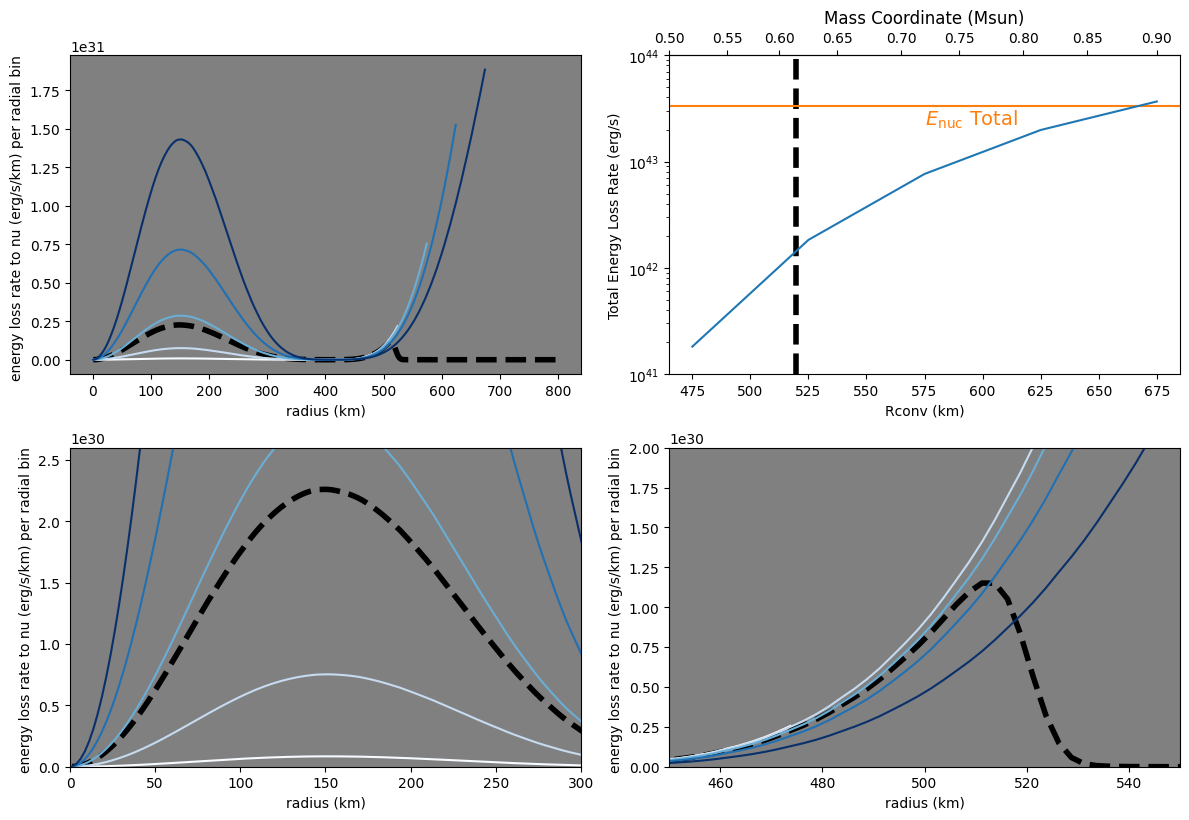

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axl, axr = axes[0, :]
ax_ecap, ax_beta = axes[1, :]

axl.plot(rad_arr/1e5, nu_loss_arr/dr/1e5, 'k--', lw=4, label='Actual (avg)')
ax_ecap.plot(rad_arr/1e5, nu_loss_arr/dr/1e5, 'k--', lw=4, label='Actual (avg)')
ax_beta.plot(rad_arr/1e5, nu_loss_arr/dr/1e5, 'k--', lw=4, label='Actual (avg)')

# define a list of ratios to check
nu_total = []
special_df = full_df.copy()
special_df['X(ne23)'] = 4e-4
special_df['X(na23)'] = 4e-4

# plot out the radial things
cmap_range = np.max(conv_sizes) - np.min(conv_sizes)
for curr_Rconv, curr_ratio in zip(conv_sizes, conv_quick_ratios):
    curr_color = cmap((curr_Rconv - np.min(conv_sizes))/cmap_range)
    
    ratio_rad, curr_nu_loss_arr = calc_const_nu_loss(curr_ratio, special_df, mass, curr_Rconv)
    l, = axl.plot(ratio_rad/1e5, curr_nu_loss_arr/dr/1e5, '-', c = curr_color , label=f"Ratio of Xne23/Xa23 = {curr_ratio:0.0f}")
    ax_ecap.plot(ratio_rad/1e5, curr_nu_loss_arr/dr/1e5, '-', c = curr_color, label=f"Ratio of Xne23/Xa23 = {curr_ratio:0.0f}")
    ax_beta.plot(ratio_rad/1e5, curr_nu_loss_arr/dr/1e5, '-', c = curr_color, label=f"Ratio of Xne23/Xa23 = {curr_ratio:0.0f}")
    

    """#annotate text
    if curr_ratio != 100:
        text_idx = np.argmin(np.abs(ratio_rad/1e5 - 150))
        axl.text(ratio_rad[text_idx]/1e5, curr_nu_loss_arr[text_idx]/dr/1e5, f"{curr_ratio:0.0f}", color=l.get_color(), fontsize=12)

        if curr_ratio != 9:
            axb.text(ratio_rad[-1]/1e5+1, curr_nu_loss_arr[-1]/dr/1e5-5e28, f"{curr_ratio:0.0f}", color=l.get_color(), fontsize=12)
        else:
            axb.text(ratio_rad[-1]/1e5+1, curr_nu_loss_arr[-1]/dr/1e5-1e29, f"{curr_ratio:0.0f}", color=l.get_color(), fontsize=12)

    elif curr_ratio == 100:
        text_idx = np.argmin(np.abs(ratio_rad/1e5 - 150))
        axl.text(ratio_rad[text_idx]/1e5, -curr_nu_loss_arr[text_idx]/dr/1e5, f"{curr_ratio:0.0f}", color=l.get_color(), fontsize=12)

        axb.text(ratio_rad[-1]/1e5-5, curr_nu_loss_arr[-1]/dr/1e5+5e28, f"{curr_ratio:0.0f}", color=l.get_color(), fontsize=12)"""

    nu_total.append(np.sum(curr_nu_loss_arr))

axl.set_xlabel('radius (km)')
axl.set_ylabel('energy loss rate to nu (erg/s/km) per radial bin ')

# plot out the totals
axr.plot(conv_sizes, nu_total, '-')
axr.set_yscale('log')

# plot the actual total for comparison
lbound, rbound = axr.get_xlim()
print(lbound)
bbound, tbound = (1e41, 1e44)
axr.vlines(Rconv, bbound, tbound, colors='k', ls='--', lw=4, zorder=-1)
axr.hlines(3.32e43, lbound, rbound, colors='tab:orange', zorder=-1)
axr.text(0.5*(lbound+rbound), 2.2e43, '$\\dot{E}_{\\mathrm{nuc}}$ Total', fontsize=14,color='tab:orange')
axr.set_xlim(lbound, rbound)
axr.set_ylim(bbound, tbound)

axr.set_xlabel("Rconv (km)")
axr.set_ylabel("Total Energy Loss Rate (erg/s)")

# ecap zone zoom in
ax_ecap.set_xlim(0, 300)
ax_ecap.set_ylim(0, 2.6e30)

# beta zone zoom in
ax_beta.set_xlim(450, 550)
ax_beta.set_ylim(0, 2e30)

ax_ecap.set_xlabel('radius (km)')
ax_ecap.set_ylabel('energy loss rate to nu (erg/s/km) per radial bin ')
ax_beta.set_xlabel('radius (km)')
ax_beta.set_ylabel('energy loss rate to nu (erg/s/km) per radial bin ')


fig.tight_layout()
axl.set_facecolor('grey')
ax_ecap.set_facecolor('grey')
ax_beta.set_facecolor('grey')

# adding a Mass axis on top
# Assuming km and Msun
Msun = 1 * unyt.Msun
Msun = Msun.in_units('g').value

def RtoM(Rarr):
    convMass = np.empty_like(Rarr)
    for i, R in enumerate(Rarr):
        convMass[i] = np.sum(mass[np.where(rad_arr/1e5 < R)]/Msun)
    return convMass
    
def MtoR(Marr):
    mcoord = np.cumsum(mass)/Msun

    Rarr = np.empty_like(Marr)
    for i, M in enumerate(Marr):
        idx = np.argmin(np.abs(mcoord - M))
        Rarr[i] = rad_arr[idx]/1e5
    return Rarr
    
axr.secondary_xaxis('top', functions=(RtoM, MtoR))
axr.set_title("Mass Coordinate (Msun)")

## Compare best Quick mix approx from other notebook to our model

Real = 4.266e+42
quick mix = 4.460e+42


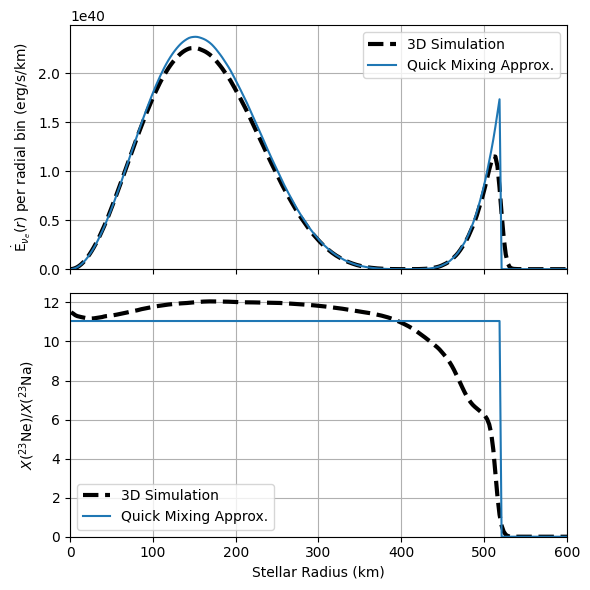

In [25]:
quick_mix_ratio = 11.04941851 # from smarter_quick_mixing.ipynb
ratio_rad, bestfit_nu_loss_arr = calc_const_nu_loss(quick_mix_ratio, special_df, mass, Rconv)
plot_bestfit_nu_loss_arr = np.zeros_like(special_df['radius'].to_numpy())
plot_bestfit_nu_loss_arr[:len(ratio_rad)] = bestfit_nu_loss_arr

plot_bestfit_ratio_arr = np.zeros_like(special_df['radius'].to_numpy())
plot_bestfit_ratio_arr[:len(ratio_rad)] = quick_mix_ratio

fig, (axt, axb) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

# plot nu loss comparison
axt.plot(rad_arr/1e5, nu_loss_arr/(dr/1e5), 'k--', lw=3, label='3D Simulation')
axt.plot(special_df['radius']/1e5, plot_bestfit_nu_loss_arr/((ratio_rad[1] -ratio_rad[0])/1e5), label='Quick Mixing Approx.')
#axt.set_xlabel('radius (km)')
axt.set_ylabel('$\\mathrm{\\dot{E}}_{\\nu_e}(r)$ per radial bin (erg/s/km)')
axt.set_xlim(0, 600)
axt.set_ylim(0.)
axt.legend()
axt.grid()

# plot Urca ratio comparison

axb.plot(real_rad, real_ratio, 'k--', lw=3, label='3D Simulation')
axb.plot(special_df['radius']/1e5, plot_bestfit_ratio_arr, label='Quick Mixing Approx.')

axb.set_xlabel('Stellar Radius (km)')
axb.set_ylabel('$X({}^{23} \\mathrm{Ne}) / X({}^{23} \\mathrm{Na})$')
axb.set_xlim(0, 600)
axb.set_ylim(0, 12.5)
axb.legend()
axb.grid()

fig.tight_layout()
fig.savefig("figures/actual_vs_best_quick_mix.png",dpi=300)
print(f"Real = {np.sum(nu_loss_arr):0.3e}")
print(f"quick mix = {np.sum(plot_bestfit_nu_loss_arr):0.3e}")

# A21 analysis
Since A21 doesn't have any sources I think the quick mixing limit is all the more relevant and a constant ratio is all the more relevant as well. at a steadyish state.

In [22]:
def calc21_weak_rates(full_df):
    # reduce the dataframe to necessary fields in right order
    cols = ['rho', 'tfromp', 'X(n)', 'X(h1)', 'X(he4)', 'X(c12)', 'X(o16)', 
            'X(ne20)', 'X(ne23)', 'X(na23)', 'X(mg23)']
    df = full_df[cols]

    comp = pyna.Composition(urca_net.unique_nuclei)
    
    # arrays to save rate and nuloss calculations
    ecap_rate_arr = np.empty(len(df))
    bdecay_rate_arr = np.empty(len(df))

    ecap_nu_loss_arr = np.empty(len(df))
    bdecay_nu_loss_arr = np.empty(len(df))
    # loop through and calc rate at each radial bin
    for i in range(len(df)):
        curr_comp = df.iloc[i, 2:].to_numpy()
        rho = df.iloc[i, 0]
        T = df.iloc[i, 1]
        
        #comp.set_array(curr_comp)
        Ye = 0.5#comp.eval_ye()

        ecap_rate = tl.get_rate_by_name(name='ne21(e,)f21')
        bdecay_rate = tl.get_rate_by_name(name='f21(,e)ne21')
        
        ecap_rate_arr[i] = ecap_rate.eval(T, rhoY=rho*Ye)
        bdecay_rate_arr[i] = bdecay_rate.eval(T, rhoY=rho*Ye)
        
        ecap_nu_loss_arr[i] = ecap_rate.get_nu_loss(T, rhoY=rho*Ye)
        bdecay_nu_loss_arr[i] = bdecay_rate.get_nu_loss(T, rhoY=rho*Ye)
    return ecap_rate_arr, bdecay_rate_arr, ecap_nu_loss_arr, bdecay_nu_loss_arr

In [23]:
ecap21_rate_arr, bdecay21_rate_arr, ecap21_nu_loss_arr, bdecay21_nu_loss_arr = calc21_weak_rates(full_df)

In [24]:
# define function that takes in ratio and proper data
# Then calculates the nu losses and such

def calc21_const_nu_loss(Xf21_to_Xne21, df, mass, Rconv):

    rad_arr = df['radius'].to_numpy()
    total = np.ones_like(rad_arr) * 3.74e-5
    
    # calculate the new Urca pair
    Xne21 = total/(1+Xf21_to_Xne21)
    Xf21 = Xf21_to_Xne21 * total/(1+Xf21_to_Xne21)

    # calculate the new raw rates/nu losses
    ecap21_rate_arr, bdecay21_rate_arr, ecap21_nu_loss_arr, bdecay21_nu_loss_arr = calc21_weak_rates(full_df)
    
    # restrict to looking just at the convection zone
    mask_non_conv = np.where(rad_arr/1e5 < Rconv)
    
    total = total[ mask_non_conv ]
    ratio_ecap_nu_loss = ecap21_nu_loss_arr[ mask_non_conv ]
    ratio_bdecay_nu_loss = bdecay21_nu_loss_arr[ mask_non_conv ]
    ratio_mass = mass[ mask_non_conv ]
    ratio_rad = rad_arr[mask_non_conv]
    Xne21 = Xne21[mask_non_conv]
    Xf21 = Xf21[mask_non_conv]
    
    # calculate energy lost
    nu_loss_arr =  ratio_mass * ( ratio_ecap_nu_loss * Xne21 + ratio_bdecay_nu_loss * Xf21) * unyt.avogadros_number_mks.value / 23.
    return ratio_rad, nu_loss_arr, ecap21_rate_arr[mask_non_conv]*Xne21, bdecay21_rate_arr[mask_non_conv]*Xf21

Need to find the inf/quick mixing limit. This is just the mass of betas vs the mass of ecaps right.

In [25]:
ecap21_rate_arr, bdecay21_rate_arr, ecap21_nu_loss_arr, bdecay21_nu_loss_arr = calc21_weak_rates(full_df)


conv_mass = mass[ np.where(rad_arr/1e5 < Rconv) ]
conv_ecap21 = ecap21_rate_arr[ np.where(rad_arr/1e5 < Rconv) ]
conv_bdecay21 = bdecay21_rate_arr[ np.where(rad_arr/1e5 < Rconv) ]

ecap21mass = np.sum(conv_mass * conv_ecap21 )
bdecay21mass = np.sum(conv_mass * conv_bdecay21) #do i need to limit zones. I think the rates will do that for me?

ratio_of_f21_to_ne21 = ecap21mass/bdecay21mass

print(f"Quick mixing limit of A=21 is X(f21)/X(ne21) = {ratio_of_f21_to_ne21:0.3e}")

Quick mixing limit of A=21 is X(f21)/X(ne21) = 2.181e-04


2.689070020255351e+39


Text(0, 0.5, 'change in mass frac of ne21')

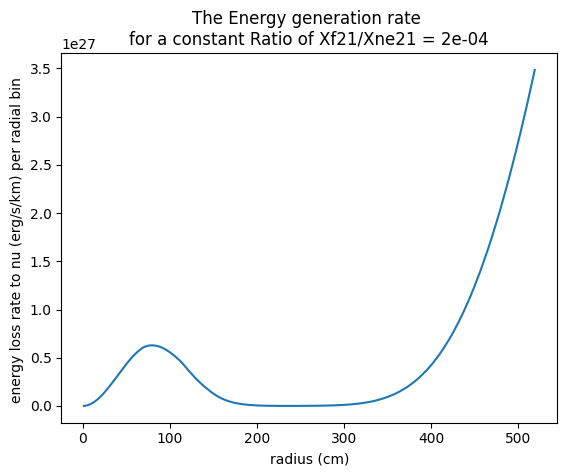

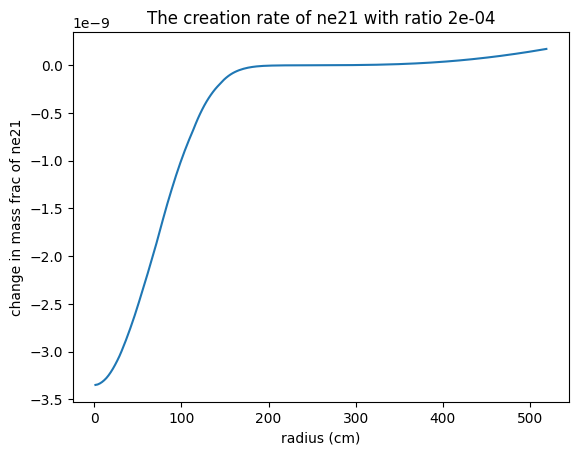

In [26]:
curr_ratio=ratio_of_f21_to_ne21
ratio_rad, curr_nu_loss_arr, e21, b21 = calc21_const_nu_loss(curr_ratio, full_df, mass, Rconv)
plt.plot(ratio_rad/1e5, curr_nu_loss_arr/dr/1e5)
plt.title(f"The Energy generation rate \nfor a constant Ratio of Xf21/Xne21 = {curr_ratio:0.0e}")
plt.xlabel('radius (cm)')
plt.ylabel('energy loss rate to nu (erg/s/km) per radial bin ')

print(np.sum(curr_nu_loss_arr))

plt.figure(2)
plt.plot(ratio_rad/1e5, b21-e21)
plt.title(f"The creation rate of ne21 with ratio {curr_ratio:0.0e}")
plt.xlabel('radius (cm)')
plt.ylabel('change in mass frac of ne21')


Text(0, 0.5, 'change in mass frac of ne21')

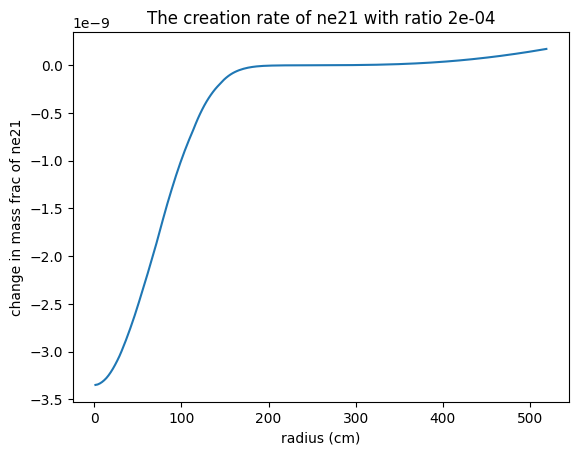

In [27]:
plt.plot(ratio_rad/1e5, b21-e21)
plt.title(f"The creation rate of ne21 with ratio {curr_ratio:0.0e}")
plt.xlabel('radius (cm)')
plt.ylabel('change in mass frac of ne21')

2.689070020255351e+39


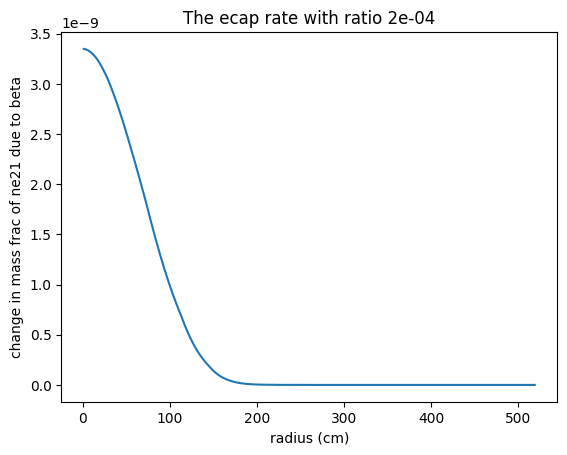

In [28]:
plt.plot(ratio_rad/1e5, e21)
plt.title(f"The ecap rate with ratio {curr_ratio:0.0e}")
plt.xlabel('radius (cm)')
plt.ylabel('change in mass frac of ne21 due to beta')

print(np.sum(curr_nu_loss_arr))

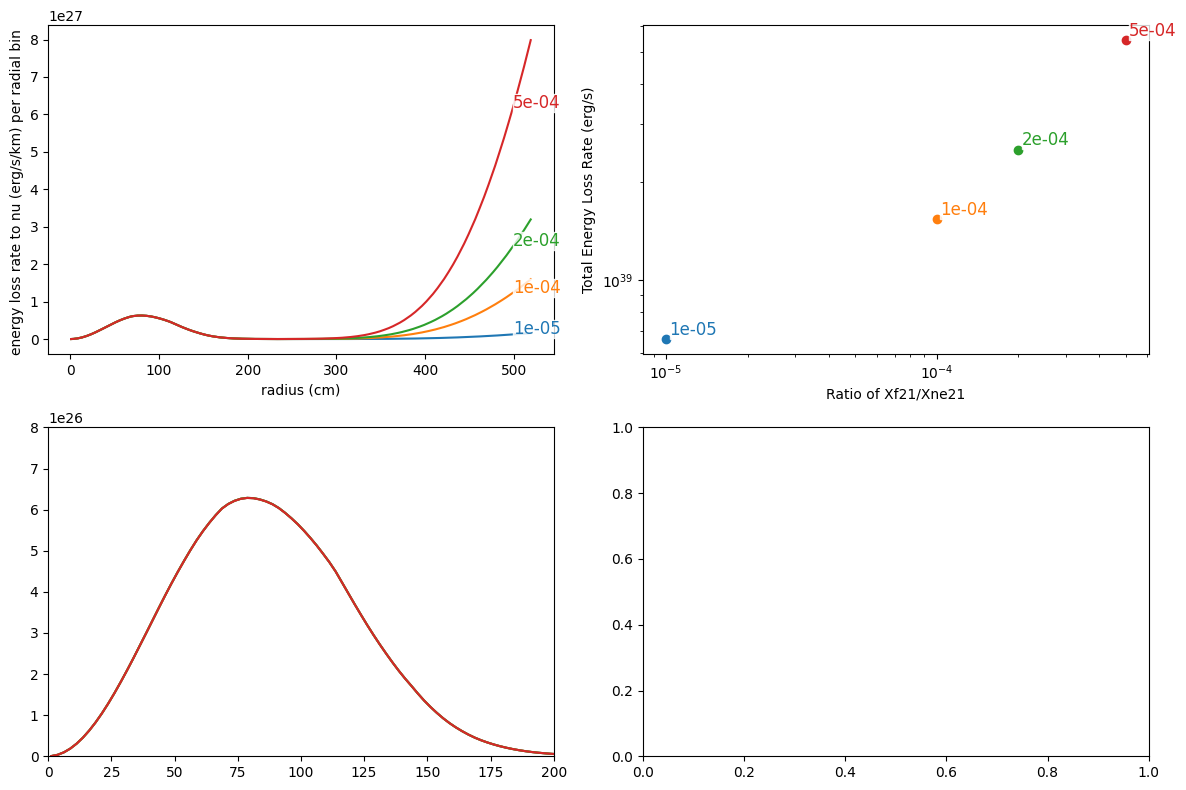

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axl, axr = axes[0, :]
axb = axes[1, 0]

#axl.plot(rad_arr/1e5, nu_loss_arr/dr/1e5, 'k--', lw=4, label='Actual (avg)')
#axb.plot(rad_arr/1e5, nu_loss_arr/dr/1e5, 'k--', lw=4, label='Actual (avg)')

# define a list of ratios to check
ratio_list = [1e-5, 1e-4, 2e-4, 5e-4]
nu_total = []

# plot out the radial things
for i, curr_ratio in enumerate(ratio_list):
    ratio_rad, curr_nu_loss_arr,_,__ = calc21_const_nu_loss(curr_ratio, full_df, mass, Rconv)
    l, = axl.plot(ratio_rad/1e5, curr_nu_loss_arr/dr/1e5, '-', label=f"Ratio of Xf21/Xne21 = {curr_ratio:0.0e}")
    axb.plot(ratio_rad/1e5, curr_nu_loss_arr/dr/1e5, '-', label=f"Ratio of Xf21/Xne21 = {curr_ratio:0.0e}")
    

    #annotate text
    text_idx = np.argmin(np.abs(ratio_rad/1e5 - 500))
    axl.text(ratio_rad[text_idx]/1e5, curr_nu_loss_arr[text_idx]/dr/1e5, f"{curr_ratio:0.0e}",
             color=l.get_color(), fontsize=12, bbox= dict(fc="white", ec="white", alpha=0.8, pad=0.))

    #axb.text(ratio_rad[-1]/1e5+1, curr_nu_loss_arr[-1]/dr/1e5, f"{curr_ratio:0.0e}", color=l.get_color(), fontsize=12)

    curr_tot = np.sum(curr_nu_loss_arr)
    axr.loglog(curr_ratio, curr_tot, 'o', color=l.get_color())
    axr.text(curr_ratio*1.03, curr_tot*1.03, f"{curr_ratio:0.0e}", color=l.get_color(), fontsize=12,
             bbox= dict(fc="white", ec="white", alpha=0.8, pad=0.))
    
    nu_total.append(curr_tot)

axl.set_xlabel('radius (cm)')
axl.set_ylabel('energy loss rate to nu (erg/s/km) per radial bin ')

# plot out the totals
# axr.loglog(ratio_list, nu_total, 'o')

# plot the actual total for comparison
lbound, rbound = axr.get_xlim()
bbound, tbound = axr.get_ylim()
axr.hlines(actual_nu_total, lbound, rbound, colors='k', ls='--', lw=4, zorder=-1)
axr.set_xlim(lbound, rbound)
axr.set_ylim(bbound, tbound)

axr.set_xlabel("Ratio of Xf21/Xne21")
axr.set_ylabel("Total Energy Loss Rate (erg/s)")

#for r, tot in zip(ratio_list, nu_total):
#    axr.text(r*1.03, tot*1.03, f"{r:0.0e}", color='tab:blue', fontsize=12)

# beta zone zoom in
axb.set_xlim(0, 200)
axb.set_ylim(0, 8e26)
fig.tight_layout()

# Looking at contribution of c12 burning

(10000.0, 10000000.0)

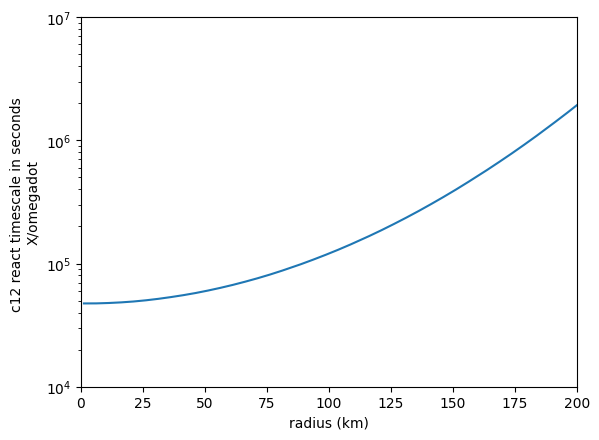

In [30]:
xc12 = full_df['X(c12)'].to_numpy()
omegadot_c12 = full_df['omegadot(c12)'].to_numpy()

plt.plot(full_df['radius']/1e5, xc12/np.abs(omegadot_c12))
plt.xlabel("radius (km)")
plt.ylabel("c12 react timescale in seconds \nX/omegadot")
plt.yscale('log')
plt.xlim(0, 200)
plt.ylim(1e4, 1e7)

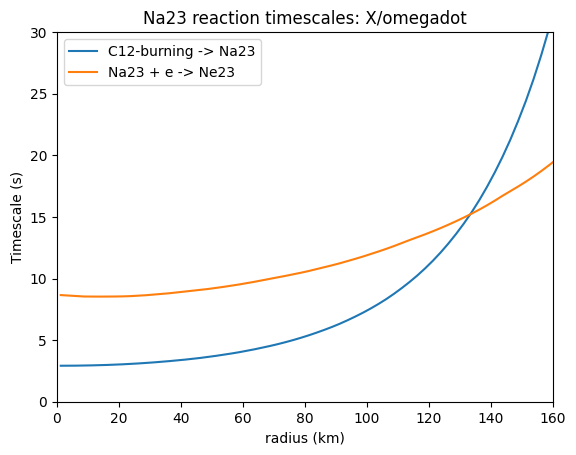

In [31]:
xna23 = full_df['X(na23)'].to_numpy()
omegadot_na23_by_c12 = full_df['omegadot(na23)'].to_numpy() + full_df['omegadot(ne23)'].to_numpy()

plt.plot(full_df['radius']/1e5, xna23/np.abs(omegadot_na23_by_c12), label='C12-burning -> Na23')
plt.plot(full_df['radius']/1e5, xna23/np.abs(full_df['omegadot(ne23)'].to_numpy()), label='Na23 + e -> Ne23')
plt.xlabel("radius (km)")
plt.ylabel("Timescale (s)")
plt.title("Na23 reaction timescales: X/omegadot")

#plt.yscale('log')
plt.xlim(0, 160)
plt.ylim(0, 30)
plt.legend()

Okay so c12 significantly contributes to na23 and dominates in the inner 140km or so. So we need to account for this to get a proper distribution. rn in my head I have:

* Sum up Na23 contributions
* Sum up Ne23 contributions
* Find Mass frac of Na23/Ne23 where sums are equivalent. ie balance of na23 create and na23 create.
* Careful b/c Urca create and destroy equivalently, so I think just need to consider either one isotope or only one half of the reactions.

Okay so approach, find composition such that Na23 number is preserved? that doesn't makes sense because its increasing. Find composition such that ratio is preserved.

* eqn saying `cburn + ecap = bdecay`
* eqn saying AVG.`X(ne23)/X(na23) = constant`
* figure it out from there? I think I may be able to set this up. I think need to find the cburn part and keep that constant.

so:
$$ \Delta_t M_{\beta} = X({}^{23}\mathrm{Ne}) \int_0^{R_{\mathrm{conv}}} \rho r_{\beta} dV$$
$$ \Delta_t M_{\mathrm{ecap}} = X({}^{23}\mathrm{Na}) \int_0^{R_{\mathrm{conv}}} \rho r_{\mathrm{ecap}} dV$$
$$ \Delta_t M_{\mathrm{c12-to-na23}} = \int_0^{R_{\mathrm{conv}}} \rho X({}^{12}\mathrm{C})r_{\mathrm{c12-to-na23}} dV$$

Now we have two equations:
$$ \dot{M}_{\mathrm{conv}} + \Delta_t M_{\mathrm{c12-to-na23}} + \Delta_t M_{\beta} - \Delta_t M_{\mathrm{ecap}} =  \Delta_t M_{\mathrm{Na23}} $$
$$  \Delta_t M_{\mathrm{ecap}} - \Delta_t M_{\beta} =  \Delta_t M_{\mathrm{Ne23}} $$

Then we posit the equilibrium:
$$   M_{\mathrm{Ne23}} / M_{\mathrm{Na23}} =  (M_{\mathrm{Ne23}} +  \Delta_t M_{\mathrm{Ne23}} )/ (M_{\mathrm{Na23}} + \Delta_t M_{\mathrm{Na23}}) = C $$
Where $C$ is a constant.

Now this $\Delta_t M_{\mathrm{c12-to-na23}}$ will be constant b/c it doesn't depend on the URca composition really. so instead we just need to tweak the mass fractions to get everything else to equal out. I don't think I can do this analytically tho just because wed pull out the mass fracs but the constant mucks things up. 

Luckily we have computers. I guess first test is see if this is consistent with our simulation at all. I'm not sure it should be but I kinda think it should be close?

In [32]:
ds0.sphere(ds.domain_center, (465, 'km')).sum('mass').in_units('Msun')

NameError: name 'ds0' is not defined

In [ ]:
ds0.sphere(ds.domain_center, (440, 'km')).sum('mass').in_units('Msun')

In [ ]:
import yt
import unyt 
data_dir = "/home/biboyd/workspace/nersc_sims/SIM_DATA/myfix_urca2048_lev4/"

ds = yt.load(f"{data_dir}/plt0163536/")
ds0 = yt.load(f"{data_dir}/plt0000000/")
ds_nu = yt.load(f"{data_dir}/nu_loss.plt0163536/")

def _mass_for_nu(field, data):
    return data[('boxlib', 'density')] * data[('boxlib', 'volume')]

def _beta_rate(field, data):
    return data[("boxlib", "A23_beta_decay_rate")]/data[("boxlib", "X(ne23)")] /unyt.s

def _ecap_rate(field, data):
    return data[("boxlib", "A23_electron_capture_rate")]/data[("boxlib", "X(na23)")]/unyt.s

def _mass_beta(field, data):
    return data[("boxlib", "raw beta rate")] * data[("gas", "mass")] 

def _mass_ecap(field, data):
    return data[("boxlib", "raw ecap rate")] * data[("gas", "mass")]

ds_nu.add_field(('gas', 'mass'), _mass_for_nu, sampling_type='local', units='g', force_override=True)

ds_nu.add_field(
    name=("boxlib", "raw beta rate"),
    function=_beta_rate,
    take_log=True,
    units='1/s',
    display_name="raw beta rate",
    sampling_type="local", force_override=True)

ds_nu.add_field(
    name=("boxlib", "raw ecap rate"),
    function=_ecap_rate,
    take_log=True,
    units='1/s',
    display_name="raw ecap rate",
    sampling_type="local", force_override=True)

ds_nu.add_field(
    name=("boxlib", "mass beta"),
    function=_mass_beta,
    take_log=True,
    units='g/s',
    display_name=" beta mass",
    sampling_type="local", force_override=True)

ds_nu.add_field(
    name=("boxlib", "mass ecap"),
    function=_mass_ecap,
    take_log=True,
    units='g/s',
    display_name="ecap mass",
    sampling_type="local", force_override=True)


okay first checking what our actual sim says about all this

In [ ]:
sph_conv = ds.sphere(ds.domain_center, (Rconv, 'km'))
sph_nu = ds_nu.sphere(ds_nu.domain_center, (Rconv, 'km'))

def _ne23_mass(field, data):
    return data[('cell_volume')]*data[('gas', 'ne23_density')]
def _na23_mass(field, data):
    return data[('cell_volume')]*data[('gas', 'na23_density')]
def _c12_mass(field, data):
    return data[('cell_volume')]*data[('gas', 'c12_density')]

def _c12_to_na23(field, data):
    return data[("omegadot(na23)")] + data[("omegadot(ne23)")]


def _c12_to_na23_mass(field, data):
    return (data[("omegadot(na23)")] + data[("omegadot(ne23)")])* data[('mass')]
    
ds.add_field(
    name=("boxlib", "ne23_mass"),
    function=_ne23_mass,
    take_log=True,
    units='g',
    display_name="ne23 mass",
    sampling_type="local", force_override=True)

ds.add_field(
    name=("boxlib", "na23_mass"),
    function=_na23_mass,
    take_log=True,
    units='g',
    display_name="na23 mass",
    sampling_type="local", force_override=True)

ds.add_field(
    name=("boxlib", "c12_mass"),
    function=_c12_mass,
    take_log=True,
    units='g',
    display_name="c12 mass",
    sampling_type="local", force_override=True)

ds.add_field(
    name=("boxlib", "c12_to_na23"),
    function=_c12_to_na23,
    take_log=True,
    units='1/s',
    display_name="c12 to na23",
    sampling_type="local", force_override=True)

ds.add_field(
    name=("boxlib", "c12_to_na23_mass"),
    function=_c12_to_na23_mass,
    take_log=True,
    units='g/s',
    display_name="c12 to na23 mass",
    sampling_type="local", force_override=True)

In [ ]:
Mne23 = sph_conv.sum('ne23_mass')
Mna23 = sph_conv.sum('na23_mass')
avgne23 = sph_conv.mean('X(ne23)')#, weight='rho')
avgna23 = sph_conv.mean('X(na23)')#, weight='rho')

delta_Mecap = sph_nu.sum("mass ecap")
delta_Mbeta = sph_nu.sum("mass beta")
delta_Mc12_to_na23 = sph_conv.sum("c12_to_na23_mass")

In [ ]:
Mne23/Mna23

In [ ]:
delta_Mecap/delta_Mbeta

In [ ]:
Mconv = sph_conv.sum('mass') +.03*unyt.Msun
mconv_dot = 4.2e-5 *unyt.Msun/unyt.hr#from paper
ratio = 10.08
Xna23 = 8e-4 /(1+ratio)
Xne23 = 8e-4 /(1+1/ratio)

print(f"Starting ratio {ratio:0.2f}")
print(f'Ecap Change: {Xna23*delta_Mecap.in_units('Msun/hr'):0.2e}')
print(f'beta change: {Xne23*delta_Mbeta.in_units('Msun/hr'):0.2e}')

print(f'Mconv growth adding na23 change: {mconv_dot.in_units('Msun/hr'):0.2e}')
print(f'c12 to na23 change: {delta_Mc12_to_na23.in_units('Msun/hr'):0.2e}')
change_in_na23 = mconv_dot + delta_Mc12_to_na23 + Xne23*delta_Mbeta - Xna23*delta_Mecap 
change_in_ne23 = Xna23*delta_Mecap - Xne23*delta_Mbeta

print()
print(f"Change in na23 {change_in_na23.in_units('Msun/hr'):0.2e}")
print(f"Change in ne23 {change_in_ne23.in_units('Msun/hr'):0.2e}")
print(f"ratio of changes {change_in_ne23/change_in_na23:0.2}")

final_Xna23 = change_in_na23*unyt.hr/Mconv + Xna23
final_Xne23 = change_in_ne23*unyt.hr/Mconv + Xne23
print(f"predicted quick mixing final ratio: {final_Xne23/final_Xna23:0.2f}")